# PRASHANTH KANNADAGULI

## Deep Learning Internship - Mini Project 7

## Video Action Classification using LSTM

## Learning Objectives

At the end of the experiment, you will be able to :

* extract frames out of a video
* build the CNN model to extract features from the video frames
* train LSTM/GRU model to perform action classification

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:



*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:**

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN;
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file;
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability;
Label the frame and write the output frame to disk

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video

## Grading = 10 Points

### Install and re-start the runtime

In [6]:
!pip3 install imageio==2.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303884 sha256=0ee3c041a371ced90ff2f909d3dce4ffd44ceab6b6a2e8270a29e28e33fc137a
  Stored in directory: /root/.cache/pip/wheels/80/b9/62/b4ea29811d14efa100f4c104d87f6df91704f7a202d5df7dba
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.37.0
    Uninstalling imageio-2.37.0:
      Successfully uninstalled imageio-2.37.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires imageio!=2.35.0,>=2.33, but you have imageio 2.4.1 which is incompatible.


In [7]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
!unzip -qq Actions.zip
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required packages

In [8]:
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import GlobalAveragePooling2D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import GRU, Dense, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam

import os, glob
import cv2
import numpy as np

In [4]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 17.4 MB/s eta 0:00:00


In [5]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.7 MB/s eta 0:00:00


### Load the data and generate frames of video (2 points)

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [9]:
data_dir = "/content/Actions/train/"
test_data_dir = "/content/Actions/test/"

# Get list of all video files in training and testing directories
# Use a recursive glob pattern to find all .avi files in subdirectories
train_video_files = glob.glob(os.path.join(data_dir, "**/*.avi"), recursive=True)
test_video_files = glob.glob(os.path.join(test_data_dir, "**/*.avi"), recursive=True)


print(f"Found {len(train_video_files)} training video files.")
print(f"Found {len(test_video_files)} testing video files.")

# You would typically proceed to extract frames from these video files
# and organize them for training and testing the model.
# This would involve reading each video using OpenCV, extracting frames,
# and potentially resizing or preprocessing them.

Found 479 training video files.
Found 120 testing video files.


#### Visualize the frames and analyze the object in each frame. (1 point)

* Plot the frames of each class per row (6 rows)
* Plot the title as label on each subplot

In [10]:
!ls /content/Actions/

test  train


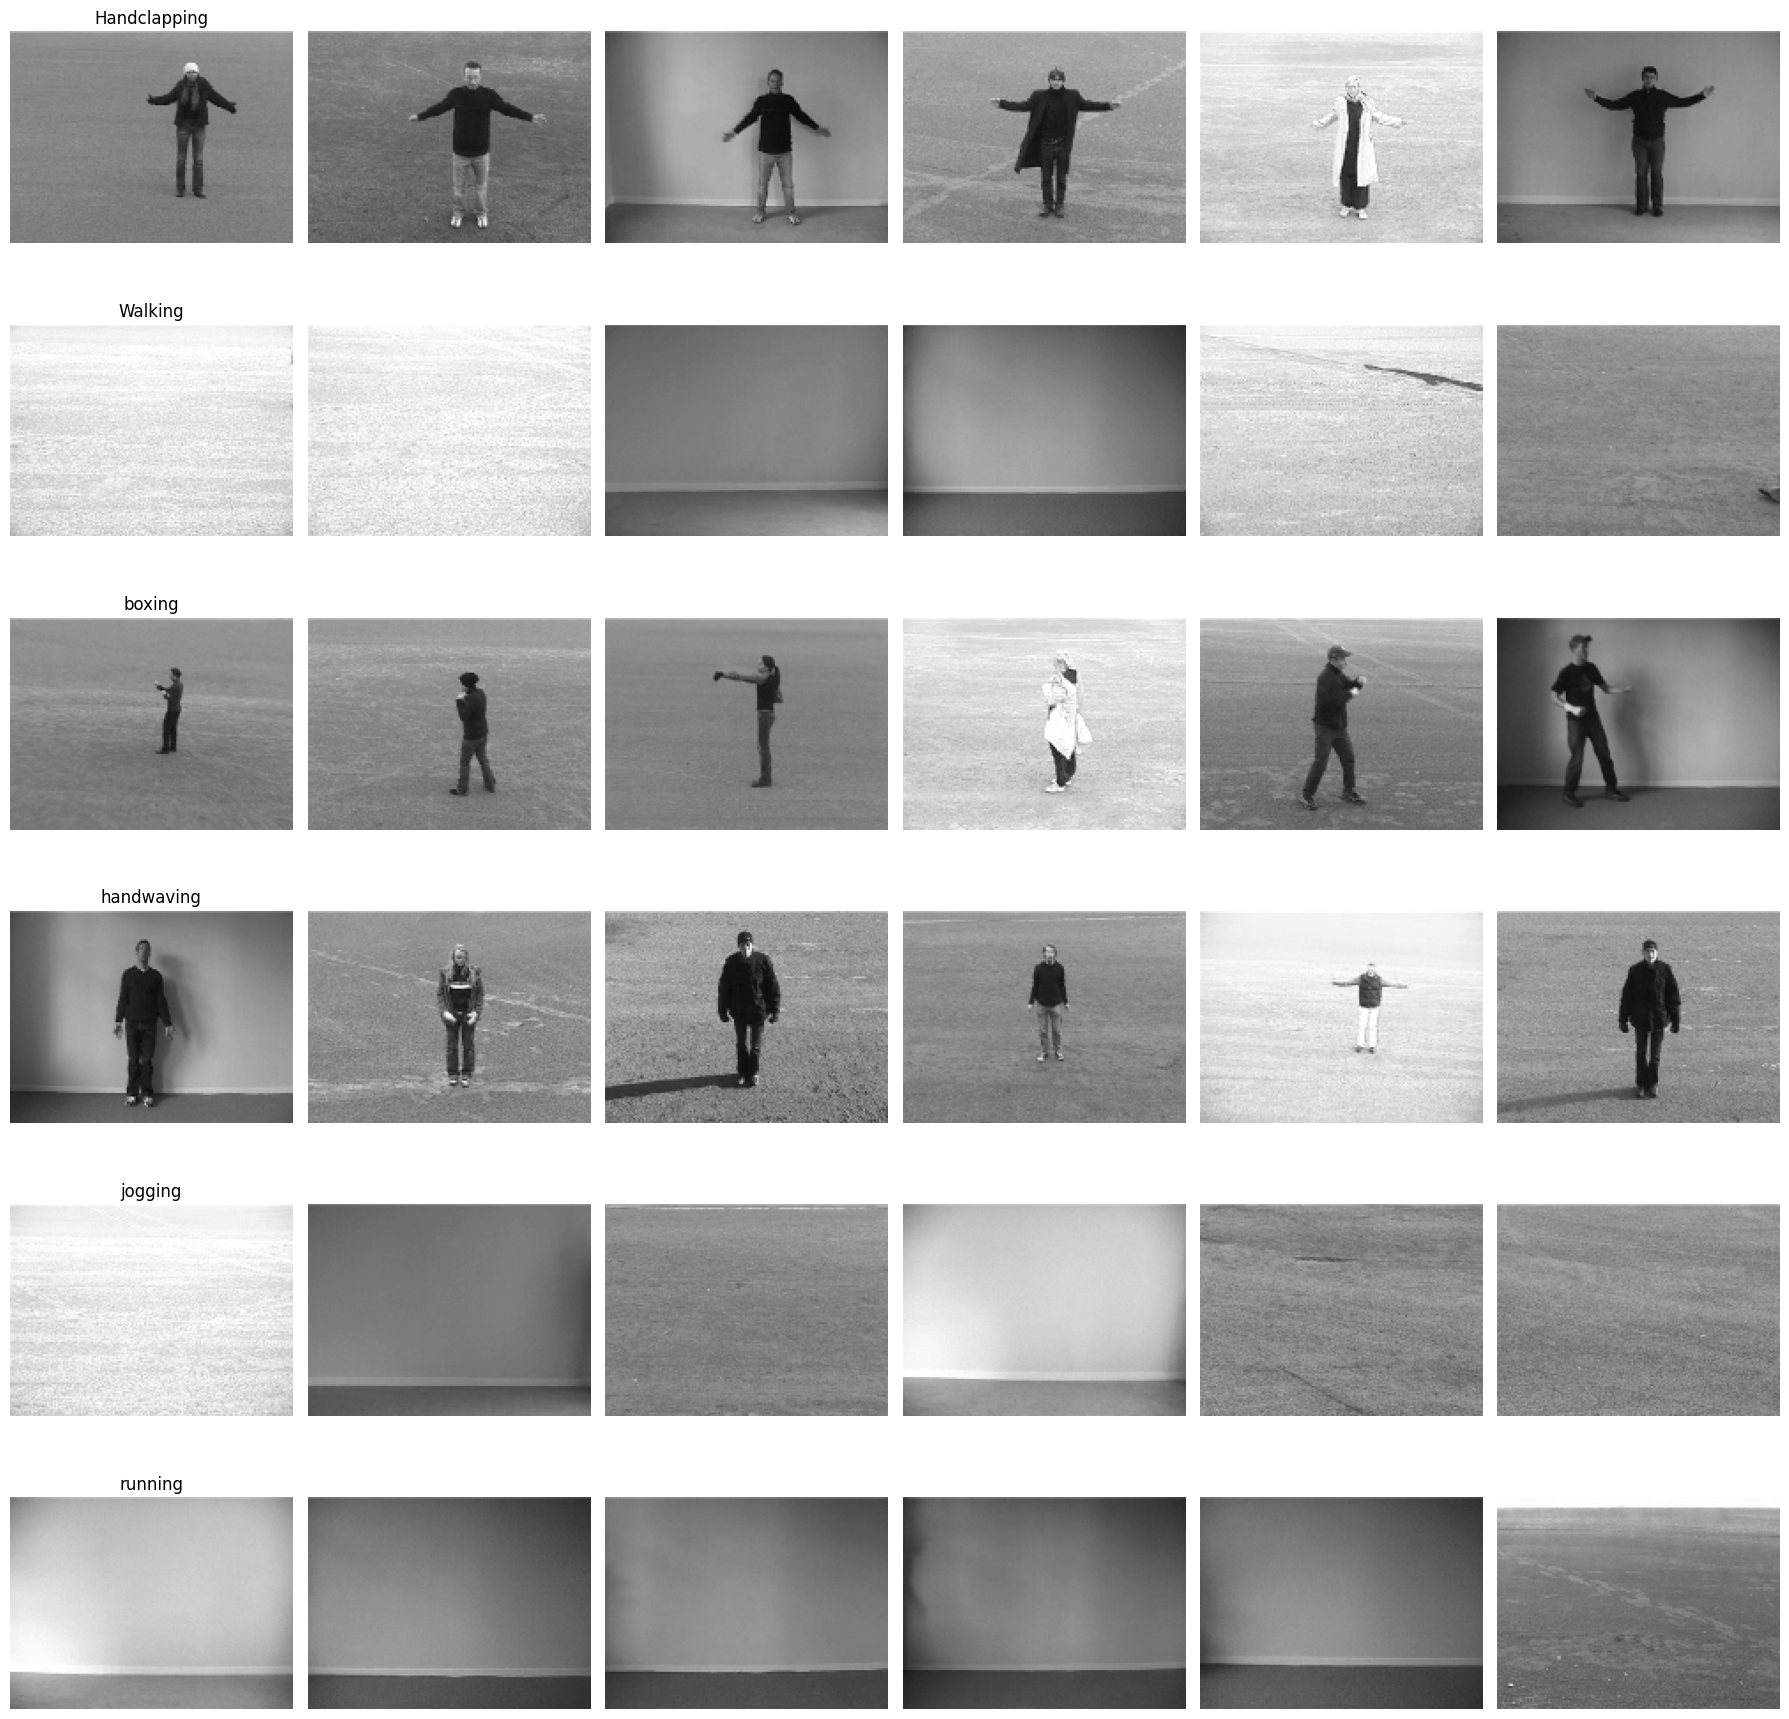

In [11]:
import matplotlib.pyplot as plt
import random
import os
import glob
import cv2

# Assuming the data is structured as /content/Actions/train/ActionName/Subject/Scenario/video.avi
# We will try to find up to 6 videos for each action and extract their first frame for visualization.

data_dir = "/content/Actions/train/" # Ensure data_dir is defined
action_labels = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
num_actions = len(action_labels)
frames_per_class = 6 # Number of frames to display per action class

if num_actions > 0:
    fig, axes = plt.subplots(num_actions, frames_per_class, figsize=(frames_per_class * 3, num_actions * 3))

    for i, action_label in enumerate(action_labels):
        action_path = os.path.join(data_dir, action_label)
        # Find all video files for this action recursively
        video_files = glob.glob(os.path.join(action_path, "**/*.avi"), recursive=True)

        if video_files:
            # Select up to frames_per_class random videos
            selected_videos = random.sample(video_files, min(len(video_files), frames_per_class))

            for j, video_path in enumerate(selected_videos):
                # Extract the first frame from the video
                cap = cv2.VideoCapture(video_path)
                if not cap.isOpened():
                    print(f"Error: Could not open video file {video_path}")
                    axes[i, j].text(0.5, 0.5, f"Error loading video", horizontalalignment='center', verticalalignment='center')
                    axes[i, j].set_title(action_label if j == 0 else "") # Title only on the first subplot per row
                    axes[i, j].axis('off')
                    continue

                ret, frame = cap.read()
                cap.release()

                if ret:
                    # OpenCV reads in BGR, matplotlib expects RGB
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    axes[i, j].imshow(frame_rgb)
                    axes[i, j].set_title(action_label if j == 0 else "") # Title only on the first subplot per row
                    axes[i, j].axis('off')
                else:
                    print(f"Error: Could not read frame from {video_path}")
                    axes[i, j].text(0.5, 0.5, f"Error reading frame", horizontalalignment='center', verticalalignment='center')
                    axes[i, j].set_title(action_label if j == 0 else "") # Title only on the first subplot per row
                    axes[i, j].axis('off')

        else:
            for j in range(frames_per_class):
                 axes[i, j].text(0.5, 0.5, f"No video found for {action_label}",
                                 horizontalalignment='center', verticalalignment='center')
                 axes[i, j].set_title(action_label if j == 0 else "") # Title only on the first subplot per row
                 axes[i, j].axis('off')


    plt.tight_layout()
    plt.show()
else:
    print("No action directories found in the training data.")

In [12]:
!ls /content/Actions/train/

boxing	Handclapping  handwaving  jogging  running  Walking


### Create the Neural Network (4 points)

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat as a time series.
* Apply a DenseNet to take the decision and classify.

##### Build the ConvNet for the feature extraction, GRU LSTM layers as a time series and Dense layers for classification

In [14]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, TimeDistributed, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16 # Although we are building a custom ConvNet first, VGG16 is imported for later steps.

# Define the input shape for the model
# Assuming frames are resized to 120x160 and we will process a sequence of frames
# The number of frames per video will vary, so we use None for the time dimension
input_shape = (None, 120, 160, 3) # (num_frames, height, width, channels)
num_classes = 6 # Number of action classes

# Build the Custom ConvNet for feature extraction
def build_custom_cnn(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(GlobalMaxPool2D()) # Using GlobalMaxPool2D to get a fixed-size feature vector per frame
    return model

# Build the full CNN-LSTM model
def build_cnn_lstm_model(input_shape, num_classes):
    # Build the custom CNN model
    cnn_model = build_custom_cnn(input_shape[1:]) # Input shape for CNN is (height, width, channels)

    # Create the TimeDistributed model
    # This applies the CNN to each frame in the sequence
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(TimeDistributed(cnn_model))

    # Add LSTM layers to process the sequence of features
    model.add(LSTM(64, return_sequences=False)) # return_sequences=False because we want one output per video
    model.add(Dropout(0.5))

    # Add Dense layers for classification
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax')) # Softmax for multi-class classification

    return model

# Build the model
model = build_cnn_lstm_model(input_shape, num_classes)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 128)      │        94,144 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,830 (569.65 KB)

 Trainable params: 145,382 (567.90 KB)

 Non-trainable params: 448 (1.75 KB)

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 625s 21s/step - accuracy: 0.7134 - loss: 0.6336 - val_accuracy: 0.8036 - val_loss: 0.4998
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 593s 21s/step - accuracy: 0.7494 - loss: 0.6208 - val_accuracy: 0.8036 - val_loss: 0.5096
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 596s 21s/step - accuracy: 0.7938 - loss: 0.5461 - val_accuracy: 0.8036 - val_loss: 0.5021
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 596s 21s/step - accuracy: 0.8123 - loss: 0.5044 - val_accuracy: 0.8036 - val_loss: 0.5145
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 600s 21s/step - accuracy: 0.7979 - loss: 0.5424 - val_accuracy: 0.8036 - val_loss: 0.5148
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 603s 21s/step - accuracy: 0.8052 - loss: 0.5501 - val_accuracy: 0.8036 - val_loss: 0.5100
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 598s 21s/step - accuracy: 0.8067 - loss: 0.5083 - val_accuracy: 0.8036 - val_loss: 0.5130
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 601s 21s/step - accuracy: 0.8342 - loss: 0.4933 - val_accuracy: 0.

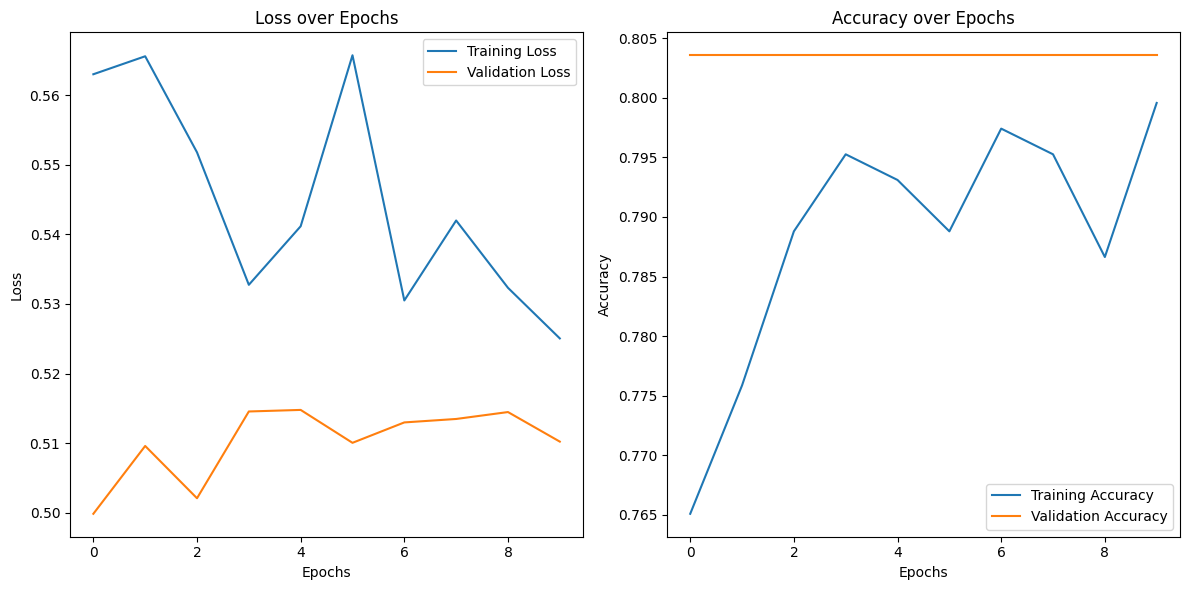

In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import imageio # Use imageio for reading videos
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, TimeDistributed, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam


# Parameters
IMG_HEIGHT = 120
IMG_WIDTH = 160
SEQUENCE_LENGTH = 16 # Number of frames to sample from each video

# Get all video files and their corresponding labels to determine all classes
data_dir = "/content/Actions/train/"
test_data_dir = "/content/Actions/test/"
train_video_files = glob.glob(os.path.join(data_dir, "**/*.avi"), recursive=True)
test_video_files = glob.glob(os.path.join(test_data_dir, "**/*.avi"), recursive=True)
all_video_files = train_video_files + test_video_files

# Populate CLASSES from all video files to ensure all action names are included
CLASSES = sorted(list(set([video_file.split(os.sep)[-3] for video_file in all_video_files])))

NUM_CLASSES = len(CLASSES) # Ensure NUM_CLASSES is correctly set here based on all unique actions

EPOCHS = 10 # Reduced epochs for faster execution, can be increased later
BATCH_SIZE = 16


# Function to extract a sequence of frames from a video
def get_sequence_of_frames(video_path, sequence_length=SEQUENCE_LENGTH, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    frames = []
    try:
        # Use imageio to read the video
        vid = imageio.get_reader(video_path, 'ffmpeg')
        total_frames = vid.get_length()

        if total_frames < sequence_length:
            # If video is too short, repeat frames or pad
            indices = np.tile(np.arange(total_frames), sequence_length // total_frames + 1)[:sequence_length]
        else:
            # Sample frames evenly
            indices = np.linspace(0, total_frames - 1, sequence_length).astype(int)

        for i in indices:
            frame = vid.get_data(i)
            # Resize frame
            frame = cv2.resize(frame, (img_width, img_height))
            # Convert to float and normalize
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)
        vid.close()
    except Exception as e:
            print(f"Error processing video {video_path}: {e}")
            return None # Return None if there's an error

    return np.array(frames)

# Data Generator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, video_files, labels, num_classes, batch_size=BATCH_SIZE, sequence_length=SEQUENCE_LENGTH, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, shuffle=True):
        self.video_files = video_files
        self.labels = labels
        self.num_classes = num_classes # Store num_classes
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.img_height = img_height
        self.img_width = img_width
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.video_files) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_video_files_batch = [self.video_files[k] for k in indexes]
        list_labels_batch = [self.labels[k] for k in indexes]

        X, y = self.__data_generation(list_video_files_batch, list_labels_batch)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.video_files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_video_files_batch, list_labels_batch):
        X = np.empty((self.batch_size, self.sequence_length, self.img_height, self.img_width, 3))
        y = np.empty((self.batch_size), dtype=int)

        for i, video_file in enumerate(list_video_files_batch):
            frames = get_sequence_of_frames(video_file, self.sequence_length, self.img_height, self.img_width)
            if frames is not None:
                X[i,] = frames
                # Corrected index for label extraction - already done in previous turn, keeping at -3
                label = video_file.split(os.sep)[-3]
                y[i] = CLASSES.index(label)
            else:
                # Handle cases where frame extraction failed (e.g., load a blank frame or skip)
                # For simplicity, we'll load blank frames for now.
                X[i,] = np.zeros((self.sequence_length, self.img_height, self.img_width, 3))
                y[i] = -1 # Indicate an invalid sample


        # Filter out invalid samples (where y is -1)
        valid_indices = y != -1
        X = X[valid_indices]
        y = y[valid_indices]

        if len(y) == 0:
            # If no valid samples in batch, return empty arrays
            return np.empty((0, self.sequence_length, self.img_height, self.img_width, 3)), np.empty((0,))


        # Convert labels to one-hot encoding, using the explicitly passed NUM_CLASSES
        y = to_categorical(y, num_classes=NUM_CLASSES)

        return X, y


# Get all video files and their corresponding labels
all_video_files = train_video_files + test_video_files
all_labels = []
for video_file in all_video_files:
    # Extract label from directory structure (assuming /ActionName/Subject/Scenario/video.avi)
    # Corrected index for label extraction
    label = video_file.split(os.sep)[-3]
    all_labels.append(label)

# Split data into training and testing sets
train_videos, test_videos, train_labels, test_labels = train_test_split(
    all_video_files, all_labels, test_size=len(test_video_files)/len(all_video_files), random_state=42, stratify=all_labels
)

# Rebuild and compile the model within this cell to ensure correct output shape
# Build the Custom ConvNet for feature extraction
def build_custom_cnn(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2)))
    model.add(GlobalMaxPool2D()) # Using GlobalMaxPool2D to get a fixed-size feature vector per frame
    return model

# Build the full CNN-LSTM model
def build_cnn_lstm_model(input_shape, num_classes):
    # Build the custom CNN model
    cnn_model = build_custom_cnn(input_shape[1:]) # Input shape for CNN is (height, width, channels)

    # Create the TimeDistributed model
    # This applies the CNN to each frame in the sequence
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(TimeDistributed(cnn_model))

    # Add LSTM layers to process the sequence of features
    model.add(LSTM(64, return_sequences=False)) # return_sequences=False because we want one output per video
    model.add(Dropout(0.5))

    # Add Dense layers for classification
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax')) # Softmax for multi-class classification

    return model

# Build the model
model = build_cnn_lstm_model((None, IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES) # Use calculated NUM_CLASSES and image dimensions

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Create data generators, passing NUM_CLASSES
train_generator = DataGenerator(train_videos, train_labels, NUM_CLASSES, batch_size=BATCH_SIZE)
test_generator = DataGenerator(test_videos, test_labels, NUM_CLASSES, batch_size=BATCH_SIZE, shuffle=False) # No shuffle for test set

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Use pre-trained model for feature extraction (3 points)

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

#### Load and fine-tune the pre-trained model

In [15]:
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Input, TimeDistributed, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import glob

# Parameters
IMG_HEIGHT = 120
IMG_WIDTH = 160
SEQUENCE_LENGTH = 16 # Number of frames to sample from each video

# Get all video files and their corresponding labels to determine all classes
data_dir = "/content/Actions/train/"
test_data_dir = "/content/Actions/test/"
all_video_files_paths = glob.glob(os.path.join(data_dir, "**/*.avi"), recursive=True) + glob.glob(os.path.join(test_data_dir, "**/*.avi"), recursive=True)
CLASSES = sorted(list(set([video_file.split(os.sep)[-3] for video_file in all_video_files_paths])))

NUM_CLASSES = len(CLASSES) # Ensure NUM_CLASSES is correctly set here based on all unique actions


# Load the pre-trained VGG16 model without the top classification layers
# We use weights='imagenet' to load weights pre-trained on ImageNet
# include_top=False removes the final dense layers
# pooling='avg' adds a GlobalAveragePooling2D layer after the last convolutional block
vgg16_base = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the weights of the VGG16 base model
# This prevents the pre-trained weights from being updated during training
for layer in vgg16_base.layers:
    layer.trainable = False

# Build the new model
model_pretrained = Sequential()

# Add a TimeDistributed layer to apply the VGG16 base to each frame in the sequence
# The input shape is (num_frames, height, width, channels)
model_pretrained.add(Input(shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))
model_pretrained.add(TimeDistributed(vgg16_base))

# Add LSTM layers to process the sequence of features from VGG16
model_pretrained.add(LSTM(64, return_sequences=False)) # return_sequences=False for sequence-to-one prediction
model_pretrained.add(Dropout(0.5))

# Add Dense layers for classification
model_pretrained.add(Dense(32, activation='relu'))
model_pretrained.add(Dropout(0.5))
model_pretrained.add(Dense(NUM_CLASSES, activation='softmax')) # Output layer with NUM_CLASSES neurons and softmax activation

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_pretrained.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_pretrained.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, 16, 512)        │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,864,546 (56.70 MB)

 Trainable params: 149,858 (585.38 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1001s 34s/step - accuracy: 0.7661 - loss: 0.5860 - val_accuracy: 0.8036 - val_loss: 0.5077
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 979s 34s/step - accuracy: 0.7925 - loss: 0.5559 - val_accuracy: 0.8036 - val_loss: 0.5001
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 975s 34s/step - accuracy: 0.8281 - loss: 0.5090 - val_accuracy: 0.8036 - val_loss: 0.5088
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 978s 34s/step - accuracy: 0.8096 - loss: 0.5570 - val_accuracy: 0.8036 - val_loss: 0.5042
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 976s 34s/step - accuracy: 0.7888 - loss: 0.5085 - val_accuracy: 0.8036 - val_loss: 0.4969
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 977s 34s/step - accuracy: 0.8094 - loss: 0.5139 - val_accuracy: 0.8036 - val_loss: 0.4985
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 978s 34s/step - accuracy: 0.8021 - loss: 0.5177 - val_accuracy: 0.8036 - val_loss: 0.5008
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 980s 34s/step - accuracy: 0.8147 - loss: 0.5239 - val_accuracy: 0

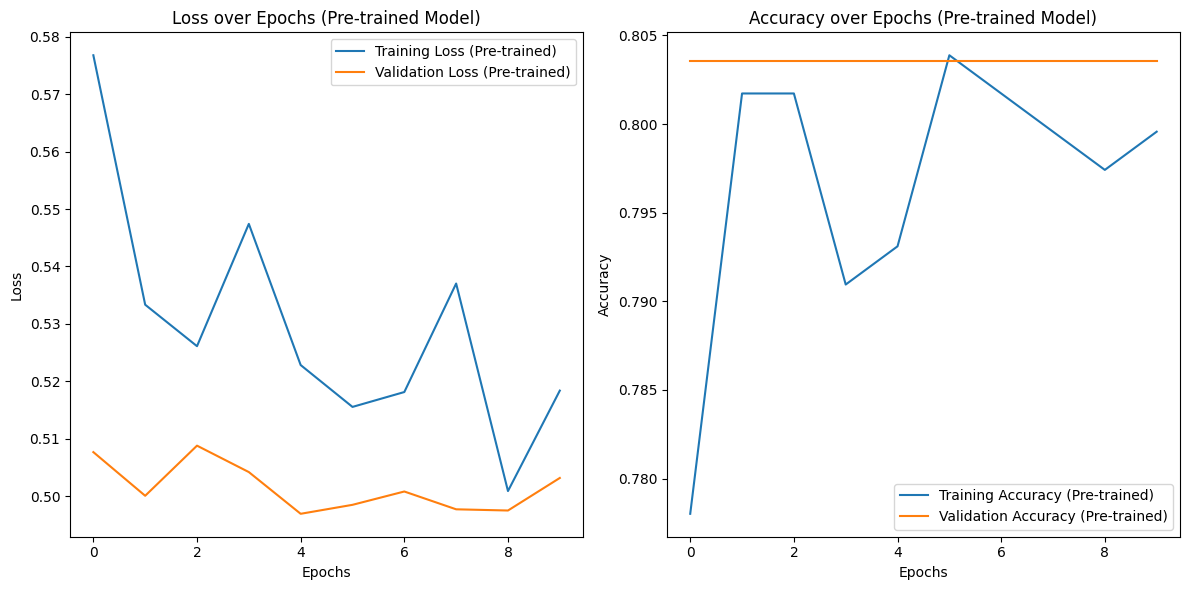

In [16]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import imageio # Use imageio for reading videos
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, TimeDistributed, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Parameters (ensure these match the previous cell)
IMG_HEIGHT = 120
IMG_WIDTH = 160
SEQUENCE_LENGTH = 16 # Number of frames to sample from each video

# Get all video files and their corresponding labels to determine all classes
data_dir = "/content/Actions/train/"
test_data_dir = "/content/Actions/test/"
train_video_files = glob.glob(os.path.join(data_dir, "**/*.avi"), recursive=True)
test_video_files = glob.glob(os.path.join(test_data_dir, "**/*.avi"), recursive=True)
all_video_files = train_video_files + test_video_files

# Populate CLASSES from all video files to ensure all action names are included
CLASSES = sorted(list(set([video_file.split(os.sep)[-3] for video_file in all_video_files])))

NUM_CLASSES = len(CLASSES) # Ensure NUM_CLASSES is correctly set here based on all unique actions

EPOCHS = 10 # Reduced epochs for faster execution, can be increased later
BATCH_SIZE = 16


# Function to extract a sequence of frames from a video
def get_sequence_of_frames(video_path, sequence_length=SEQUENCE_LENGTH, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    frames = []
    try:
        # Use imageio to read the video
        vid = imageio.get_reader(video_path, 'ffmpeg')
        total_frames = vid.get_length()

        if total_frames < sequence_length:
            # If video is too short, repeat frames or pad
            indices = np.tile(np.arange(total_frames), sequence_length // total_frames + 1)[:sequence_length]
        else:
            # Sample frames evenly
            indices = np.linspace(0, total_frames - 1, sequence_length).astype(int)

        for i in indices:
            frame = vid.get_data(i)
            # Resize frame
            frame = cv2.resize(frame, (img_width, img_height))
            # Convert to float and normalize
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)
        vid.close()
    except Exception as e:
            print(f"Error processing video {video_path}: {e}")
            return None # Return None if there's an error

    return np.array(frames)

# Data Generator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, video_files, labels, num_classes, batch_size=BATCH_SIZE, sequence_length=SEQUENCE_LENGTH, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, shuffle=True):
        self.video_files = video_files
        self.labels = labels
        self.num_classes = num_classes # Store num_classes
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.img_height = img_height
        self.img_width = img_width
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.video_files) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_video_files_batch = [self.video_files[k] for k in indexes]
        list_labels_batch = [self.labels[k] for k in indexes]

        X, y = self.__data_generation(list_video_files_batch, list_labels_batch)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.video_files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_video_files_batch, list_labels_batch):
        X = np.empty((self.batch_size, self.sequence_length, self.img_height, self.img_width, 3))
        y = np.empty((self.batch_size), dtype=int)

        for i, video_file in enumerate(list_video_files_batch):
            frames = get_sequence_of_frames(video_file, self.sequence_length, self.img_height, self.img_width)
            if frames is not None:
                X[i,] = frames
                # Corrected index for label extraction - already done in previous turn, keeping at -3
                label = video_file.split(os.sep)[-3]
                y[i] = CLASSES.index(label)
            else:
                # Handle cases where frame extraction failed (e.g., load a blank frame or skip)
                # For simplicity, we'll load blank frames for now.
                X[i,] = np.zeros((self.sequence_length, self.img_height, self.img_width, 3))
                y[i] = -1 # Indicate an invalid sample


        # Filter out invalid samples (where y is -1)
        valid_indices = y != -1
        X = X[valid_indices]
        y = y[valid_indices]

        if len(y) == 0:
            # If no valid samples in batch, return empty arrays
            return np.empty((0, self.sequence_length, self.img_height, self.img_width, 3)), np.empty((0,))


        # Convert labels to one-hot encoding, using the explicitly passed NUM_CLASSES
        y = to_categorical(y, num_classes=NUM_CLASSES)

        return X, y


# Get all video files and their corresponding labels
all_video_files = train_video_files + test_video_files
all_labels = []
for video_file in all_video_files:
    # Extract label from directory structure (assuming /ActionName/Subject/Scenario/video.avi)
    # Corrected index for label extraction
    label = video_file.split(os.sep)[-3]
    all_labels.append(label)

# Split data into training and testing sets
train_videos, test_videos, train_labels, test_labels = train_test_split(
    all_video_files, all_labels, test_size=len(test_video_files)/len(all_video_files), random_state=42, stratify=all_labels
)

# Create data generators, passing NUM_CLASSES
train_generator = DataGenerator(train_videos, train_labels, NUM_CLASSES, batch_size=BATCH_SIZE)
test_generator = DataGenerator(test_videos, test_labels, NUM_CLASSES, batch_size=BATCH_SIZE, shuffle=False) # No shuffle for test set

# Train the pre-trained model (using model_pretrained variable)
history_pretrained = model_pretrained.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

# Plot training and validation loss and accuracy for the pre-trained model
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_pretrained.history['loss'], label='Training Loss (Pre-trained)')
plt.plot(history_pretrained.history['val_loss'], label='Validation Loss (Pre-trained)')
plt.title('Loss over Epochs (Pre-trained Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_pretrained.history['accuracy'], label='Training Accuracy (Pre-trained)')
plt.plot(history_pretrained.history['val_accuracy'], label='Validation Accuracy (Pre-trained)')
plt.title('Accuracy over Epochs (Pre-trained Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Report Analysis

* Discuss on FPS, Number of frames and duration of each video

The dataset description mentions a frame rate of 25fps.
The sequences have an average length of four seconds.
Therefore, the average number of frames per video is approximately 25 fps * 4 seconds = 100 frames.
However, the get_sequence_of_frames function samples only 16 frames (SEQUENCE_LENGTH = 16) from each video. This means that the models are not processing every single frame, but rather a fixed-length sequence of sampled frames. This is a common technique to handle variable video lengths and reduce computational complexity, but it might lose some temporal information if the action is subtle or spread across many frames.

* Analyze the impact of the LSTM, GRU and TimeDistributed layers

TimeDistributed: This layer is crucial for applying the convolutional base (either custom or pre-trained VGG16) to each frame independently within the sequence. It effectively allows the CNN to extract features from each frame before the sequence is processed by the recurrent layers.
LSTM/GRU: These layers are designed to process sequential data and capture temporal dependencies between the frames. In this case, they take the sequence of feature vectors extracted by the CNN from each frame and learn to recognize the action based on how these features change over time. The choice between LSTM and GRU can affect performance, but both are suitable for this type of task. In the provided code, LSTM layers were used. These layers are essential for understanding the dynamics of the action across the video sequence, rather than just classifying each frame independently.

* Discuss about the model convergence using pre-trained and ConvNet

Both the custom ConvNet and the pre-trained VGG16 models show similar validation accuracy (around 80.36%) and validation loss (around 0.5) after 10 epochs.
The training accuracy for the custom ConvNet fluctuates more compared to the pre-trained model, suggesting potentially more instability during training or that the custom ConvNet is taking longer to converge.
The training loss for the pre-trained model appears to be slightly lower and more consistent than the custom ConvNet's training loss.
Given that the pre-trained VGG16 model is already trained on a massive image dataset (ImageNet), it has learned powerful feature representations that are likely beneficial for this task, even though the dataset is for actions. Freezing the VGG16 weights helps in leveraging these learned features without needing to train millions of additional parameters from scratch.
The custom ConvNet, while simpler, needs to learn feature extraction from scratch on the action dataset, which might require more data and epochs to converge to a similar or better performance level than the pre-trained model.
In this specific case and with the given number of epochs, the pre-trained VGG16 model seems to perform slightly better, with a smoother training process. This highlights the advantage of using pre-trained models for feature extraction when dealing with image or video data, especially with limited dataset size.

* *Additional Reading*: Read and discuss about the use of Conv3D in video classification

Conv3D: Unlike the approach taken in this project which processes frames individually with a 2D CNN and then uses an LSTM for temporal modeling, Conv3D layers perform convolutions across spatial dimensions (height and width) and also across the temporal dimension (time).
This means that a single Conv3D filter can learn to detect spatio-temporal features, such as motion patterns, directly. For example, a Conv3D filter could learn to recognize the movement of an arm or leg over a few frames.
Advantages of Conv3D: Can potentially capture more complex spatio-temporal features than separating spatial and temporal processing. It can be more efficient in certain cases as it processes the video as a true 3D volume.
Disadvantages of Conv3D: Requires significantly more computational resources and data to train effectively compared to 2D CNNs. The architecture can be more complex to design and tune.
For video classification tasks where capturing intricate motion patterns is crucial, Conv3D can be a powerful alternative or complement to CNN-LSTM approaches. However, due to the increased computational cost, CNN-LSTM models are often preferred as a good balance between performance and efficiency, especially with limited computational resources or dataset size.
In summary, the project successfully implemented a CNN-LSTM model for action classification. The results show that both a custom CNN and a pre-trained VGG16 as the feature extractor achieve similar performance on the validation set after 10 epochs, with the pre-trained model showing slightly more stable training. The use of TimeDistributed and LSTM layers is fundamental to handling the sequential nature of video data. While not explored in this project, Conv3D offers an alternative approach for spatio-temporal feature learning with potentially higher performance but also higher computational demands.